In [81]:
# imports
import requests
import pandas as pd
import numpy as np
import json
import os
from dotenv import load_dotenv

In [182]:
# Reading bike stations csv to dataframe
df_stations = pd.read_csv('df_stations.csv')[['id','name','total_bikes','latitude','longitude']]

# Reading bars 
df_landmarksOutdoors_fs = pd.read_csv('df_landmarksOutdoors_fs.csv')
df_landmarks_yelp = pd.read_csv('df_landmarks_yelp.csv')

In [183]:
# Check column names
print(df_stations.columns)
print(df_landmarksOutdoors_fs.columns)
print(df_landmarks_yelp.columns)


Index(['id', 'name', 'total_bikes', 'latitude', 'longitude'], dtype='object')
Index(['station_id', 'fsq_id', 'name', 'popularity', 'rating'], dtype='object')
Index(['station_id', 'id', 'alias', 'name', 'image_url', 'is_closed', 'url',
       'review_count', 'categories', 'rating', 'transactions', 'phone',
       'display_phone', 'distance', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address'],
      dtype='object')


In [184]:
# Need to adjust column names before merging
df_stations.columns = ['station_id','station_name','total_bikes', 'latitude', 'longitude']
df_landmarksOutdoors_fs.columns = ['station_id', 'fsq_id', 'POI_name', 'popularity', 'fsq_rating']
df_landmarks_yelp.columns = ['station_id', 'yelp_id', 'alias', 'POI_name', 'image_url', 'is_closed', 'url',
                                   'review_count', 'categories', 'yelp_rating', 'transactions', 'phone',
                                   'display_phone', 'distance', 'coordinates.latitude',
                                   'coordinates.longitude', 'location.address1', 'location.address2',
                                   'location.address3', 'location.city', 'location.zip_code',
                                   'location.country', 'location.state', 'location.display_address']

df_landmarks_yelp = df_landmarks_yelp[['station_id', 'yelp_id', 'alias', 'POI_name',
                                   'review_count', 'categories', 'yelp_rating']]


Join the data from Part 1 with the data from Part 2 to create a new dataframe.

### FourSquare

In [247]:
# Merge dataframes together on the 'station_id' column
df_landmarksOutdoors_fs_merged = df_landmarksOutdoors_fs.merge(df_stations,how='left',on='station_id')

In [248]:
# There are duplicate POI's in the merged tables.  They can be aggregated by creating pivot tables and finding the mean rating and popularity, and the sum of total_bikes.
pivot_fs = df_landmarksOutdoors_fs_merged.pivot_table(index=['POI_name','fsq_id'],
                          values=['popularity','fsq_rating','total_bikes'],
                          aggfunc={'popularity':np.mean,'fsq_rating':np.mean,'total_bikes':np.sum})



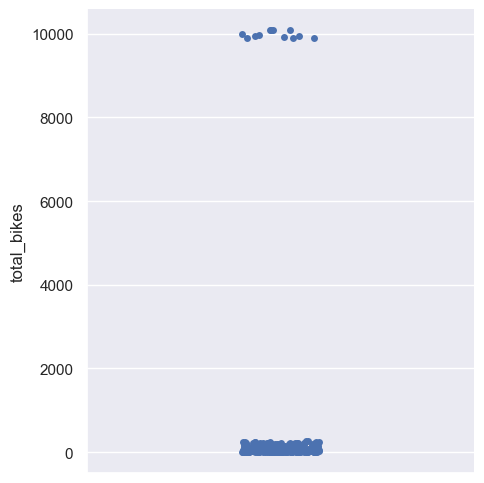

In [250]:
# When we plot total_bikes on a cat plot, there are clearly significant outliers.  Further inspection shows that these outliers are coming from a station called "Secret Warehouse"
# Dropping this outlier will make it much easier to visualize any trends.

import seaborn as sns

sns.catplot(data=pivot_fs,
            y ='total_bikes')

In [252]:
# Secret Warehouse bike station outlier
df_stations.sort_values('total_bikes',ascending=False).head()

,station_id,station_name,total_bikes,latitude,longitude
94,e8957e99332a66bd23650bc04b0c321e,Secret Warehouse,9886,33.441091,-112.082911
63,653f373dcbab60c88dfd3557facf5fef,P127 Central Ave / Roosevelt St,24,33.459103,-112.074011
3,6628d10945695a8a19a0ede32f949bc4,T17 Tempe Beach Park,23,33.429720,-111.940602
90,964777a6d0d3f562402c2e034894f5b2,T26 ASU Memorial Union,23,33.417715,-111.933633
19,c0932901743359c499780029d8549433,P133 5th Ave / McDowell Rd,20,33.465861,-112.080309


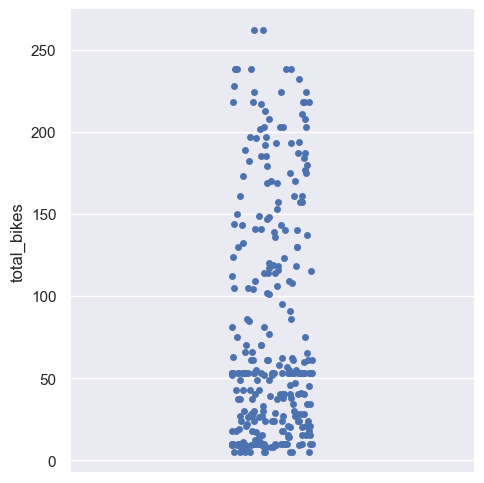

In [253]:
# Dropping outliers
pivot_fs = pivot_fs[pivot_fs['total_bikes']<1000]

sns.catplot(data=pivot_fs,
            y ='total_bikes')

<Axes: xlabel='fsq_rating', ylabel='total_bikes'>

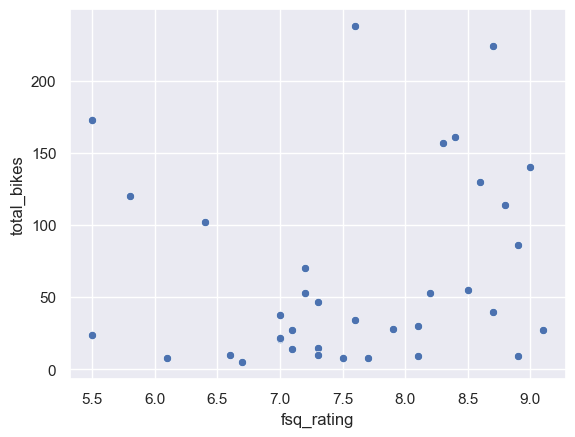

In [254]:
# Plotting total_bikes against fsq_rating and popularity to see if there are any trends
sns.scatterplot(data=pivot_fs,x='fsq_rating',y='total_bikes')

#axes[0]


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

<Axes: xlabel='popularity', ylabel='total_bikes'>

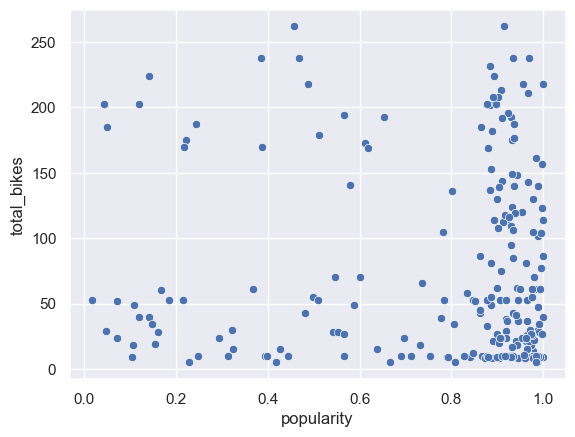

In [256]:
sns.scatterplot(data=pivot_fs,x='popularity',y='total_bikes')

### Yelp

In [ ]:
# Merge dataframes together on the 'station_id' column
df_landmarks_yelp_merged = df_landmarks_yelp.merge(df_stations,how='left',on='station_id')

In [228]:
# There are duplicate POI's in the merged tables.  They can be aggregated by creating pivot tables and finding the mean rating and popularity, and the sum of total_bikes.
pivot_yelp = df_landmarks_yelp_merged.pivot_table(index=['POI_name','yelp_id'],
                          values=['review_count','yelp_rating','total_bikes'],
                          aggfunc={'review_count':np.mean,'yelp_rating':np.mean,'total_bikes':np.sum})



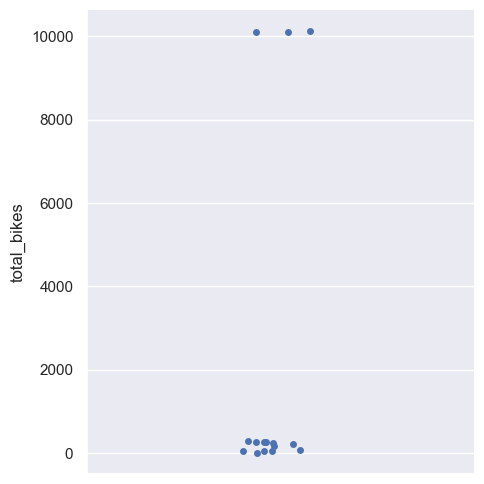

In [232]:
# When we plot total_bikes on a cat plot, there are clearly significant outliers.  Further inspection shows that these outliers are coming from a station called "Secret Warehouse"
# Dropping this outlier will make it much easier to visualize any trends.

import seaborn as sns

sns.catplot(data=pivot_yelp,
            y ='total_bikes')

In [234]:
# Dropping outliers
pivot_yelp = pivot_yelp[pivot_yelp['total_bikes']<1000]

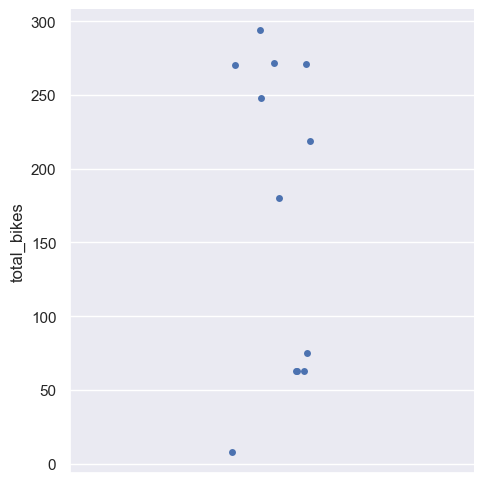

In [235]:
# Re-plotting total_bikes catplot
sns.catplot(data=pivot_yelp,
            y ='total_bikes')

<Axes: xlabel='total_bikes', ylabel='review_count'>

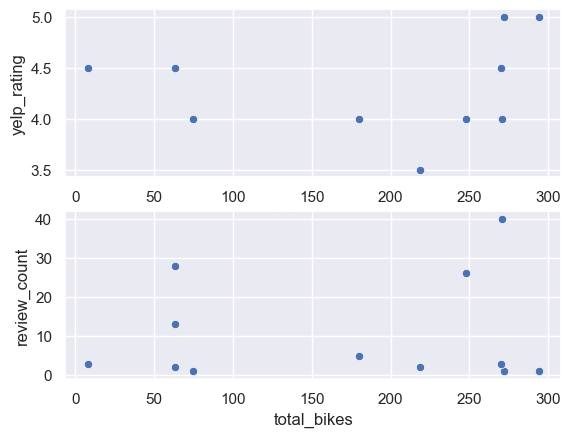

In [238]:
# Plotting total_bikes against yelp_rating and popularity to see if there are any trends
from matplotlib import pyplot as plt

fig,axes = plt.subplots(2,1)
sns.scatterplot(ax=axes[0],x=pivot_yelp['total_bikes'],y=pivot_yelp['yelp_rating'])
sns.scatterplot(ax=axes[1],x=pivot_yelp['total_bikes'],y=pivot_yelp['review_count'])

#axes[0]

In [242]:
pivot_fs.to_csv(path_or_buf='pivot_fs.csv')
pivot_yelp.to_csv(path_or_buf='pivot_yelp.csv')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.